<a href="https://colab.research.google.com/github/maxmatical/pytorch-projects/blob/master/CNN_MNIST_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%%capture
!pip install git+https://github.com/fastai/fastai.git

In [2]:
# Set up environment and download course-v3
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from fastai import *
from fastai.vision import *   

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

If you get 
```VersionConflict: (fastprogress 0.1.22 (/usr/local/lib/python3.6/dist-packages), Requirement.parse('fastprogress>=0.2.1'))```

Restart the runtime and start from the above cell


In [12]:
path = untar_data(URLs.MNIST)
path


PosixPath('/content/data/mnist_png')

In [13]:
path.ls()

[PosixPath('/content/data/mnist_png/training'),
 PosixPath('/content/data/mnist_png/testing')]

In [17]:
data = ImageDataBunch.from_folder(path, 
                                  train = 'training',
                                  ds_tfms=None,
                                  valid = 'testing',
                                  bs=64).normalize(imagenet_stats)

img,label = data.train_ds[0]
img

# Model

In [0]:
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
        
    def forward(self, x):
        return x.view(x.size(0), -1)
    
# weight initialization
def init_cnn(m):
    if getattr(m, 'bias', None) is not None: nn.init.constant_(m.bias, 0)
    if isinstance(m, (nn.Conv2d,nn.Linear)): nn.init.kaiming_normal_(m.weight)
    for l in m.children(): init_cnn(l)

# activation function
act_fn = nn.ReLU(inplace=True)

In [0]:
# default conv layer
def conv(in_channels, out_channels, kernel_size = 5, stride = 1, bias = False):
    return nn.Conv2d(in_channels, out_channels, kernel_size = kernel_size, stride = stride, 
                     padding = kernel_size//2, bias = bias)
    
# conv + bn + act_fun
def conv_layer(in_channels, out_channels, kernel_size=3, stride=1, bn=False, zero_bn=False, act=True):
    bn = nn.BatchNorm2d(out_channels)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)
    layers = [conv(in_channels, out_channels, kernel_size, stride = stride)]
    if bn:
        layers.append(bn)
    if act: 
        layers.append(act_fn)
    return nn.Sequential(*layers)

# default maxpool2d
def maxpool(kernel_size =3, stride = 2, padding = 1):
    return nn.MaxPool2d(kernel_size = kernel_size, stride = stride, padding = padding)

# linear layers
def linear(n_in, n_out):
    return nn.Linear(n_in, n_out)

def linear_layer(n_in, n_out, dp=False, dropout_rate = 0.5, bn = False, zero_bn = False, act=True):
    dropout = nn.Dropout(p=dropout_rate)
    bn = nn.BatchNorm1d(n_out)
    nn.init.constant_(bn.weight, 0. if zero_bn else 1.)

    layers = [linear(n_in, n_out)]
    if bn:
        layers.append(bn)
    if dp:
        layers.append(dropout)
    if act: 
        layers.append(act_fn)

    return nn.Sequential(*layers)


In [0]:
#test linear layer

# tmp = torch.randn(64*7*7)
# a = linear_layer(64*7*7, 1024)
# print(a(tmp).shape)

In [0]:
# simple CNN
"""
USE THIS ONE
"""
class CNN(nn.Module):
    def __init__(self, ni=3, n_classes = 10, input_size = 28):
        super(CNN, self).__init__()
        self.ni = ni
        self.n_classes = n_classes
        self.flatten_size = int((input_size/4)**2*64)
        

        layers = [conv_layer(self.ni, 50, 5), # size [50, 28, 28]
                  maxpool(), # size [50, 14, 14]
                  conv_layer(50, 64, 5), # size [64, 14, 14]
                  maxpool(), # size [64, 7, 7]
                  Flatten()] # size 64*7*7
                  
        lin_layers = [linear_layer(self.flatten_size, 1024, dp=True, dropout_rate=0.4, act=True),
                      linear_layer(1024, self.n_classes, act=False)] # no act_fn to return logits


        self.nn = nn.Sequential(*layers, *lin_layers)



    def forward(self, x):

        out = self.nn(x)
        return(out)

model = CNN()

In [23]:
# test for CNN
tmp = torch.randn((32, 3, 28, 28))
a = CNN(3, 10, 28)
print(a(tmp).shape)


torch.Size([32, 10])


In [0]:
# class CNN(nn.Module):
#     def __init__(self, ni=3, n_classes = 10, dropout_rate = 0.4, act = True):
#         super(CNN, self).__init__()
#         self.ni = ni
#         self.n_classes = n_classes
#         self.dropout_rate = dropout_rate
#         self.lin = nn.Linear(self.ni, self.n_classes)

#         layers = [conv_layer(self.ni, 50, 5), # size [50, 28, 28]
#                     maxpool(), # size [50, 14, 14]
#                     conv_layer(50, 64, 5), # size [64, 14, 14]
#                     maxpool(), # size [64,7,7]
#                     Flatten()] # size 64*7*7

#         self.convs = nn.Sequential(*layers)

#         self.lin1 = nn.Linear(64*7*7, 1024)
#         self.dropout = nn.Dropout(p=self.dropout_rate)
#         self.lin2 = nn.Linear(1024, self.n_classes)

#     def forward(self, x):
#         out = self.convs(x)
#         out = act_fn(self.dropout(self.lin1(out)))
#         out = self.lin2(out)
#         return(out)


# model = CNN()

In [25]:
# test for CNN
# tmp = torch.randn((32, 3, 28, 28))
# a = CNN(3, 10)
# print(a(tmp).shape)


torch.Size([32, 10])


# Creating fastai learner

In [26]:
model = CNN(3, 10).to(device)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.064672,0.047728,0.990500,00:24


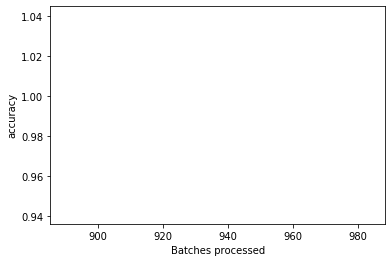

In [27]:
learn.recorder.plot_metrics()

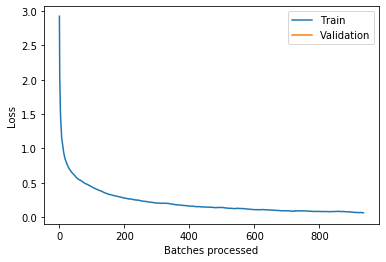

In [28]:
learn.recorder.plot_losses()

# Try on CIFAR 10

In [29]:
path = untar_data(URLs.CIFAR)
path

PosixPath('/root/.fastai/data/cifar10')

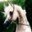

In [30]:
data = ImageDataBunch.from_folder(path, 
                                  ds_tfms=None,
                                  valid='test',
                                  bs=64).normalize(imagenet_stats)

img,label = data.train_ds[0]
img

In [31]:
model = CNN(3, 10, 32).to(device)
learn = Learner(data, model, metrics=accuracy)
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.967985,0.951247,0.670000,00:23


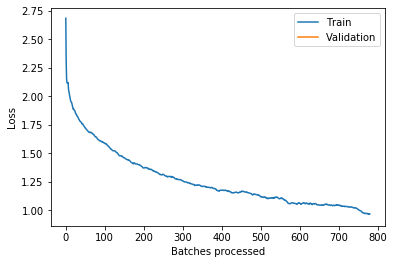

In [32]:
learn.recorder.plot_losses()

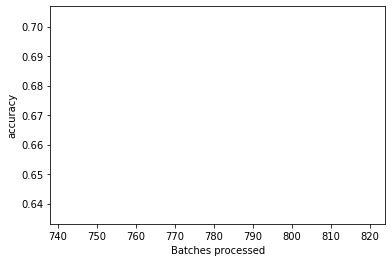

In [33]:
learn.recorder.plot_metrics()